In [1]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [2]:
def densenet(img_shape, n_classes, f=12):
    repetitions = 12, 12, 12
    
    def bn_rl_conv(x, f, k=1, s=1, p='same'):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(f, k, strides=s, padding=p)(x)
        return x
  
    def dense_block(tensor, r):
        for _ in range(r):
            x = bn_rl_conv(tensor, 4*f)
            x = bn_rl_conv(x, f, 3)
            tensor = Concatenate()([tensor, x])
        return tensor
  
  
    def transition_block(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x
  
  
    input = Input(img_shape)
    x = Conv2D(2*f, 3, strides=2, padding='same')(input)
    #x = MaxPool2D(3, strides=2, padding='same')(x)
  
    for r in repetitions:
        d = dense_block(x, r)
        x = transition_block(d)
  
    x = GlobalAvgPool2D()(d)
  
    output = Dense(n_classes, activation='softmax')(x)
  
    model = Model(input, output)
    return model

In [3]:
input_shape = 48, 48, 3
n_classes = 7

K.clear_session()
model = densenet(input_shape, n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 24)   672         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 24, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 24, 24, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
model.compile(optimizer="adam", 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [5]:
epochs = 300
batch_size = 32
target_size= 48,48

In [6]:
data_dir = 'FER+CK/train/'
val_dir = 'FER+CK/val/'
test_dir = 'FER_test/'

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        shear_range=.2,
                        horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(data_dir,
                                                    target_size=target_size,
                                                    batch_size= batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True)

datagen_val = ImageDataGenerator(featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        shear_range=.2,
                        horizontal_flip=True)

val_generator = datagen_val.flow_from_directory(val_dir,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                shuffle=False) 

Found 29430 images belonging to 7 classes.
Found 6723 images belonging to 7 classes.


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

my_callbacks = [
                EarlyStopping(monitor='val_accuracy', min_delta=1e-5, patience=20, mode='auto', verbose=1),
                ModelCheckpoint(filepath='ferck_densenetmodif_32-copy.h5', monitor='accuracy', save_best_only=True, save_weights_only=False, mode='auto', verbose=1)
]

In [11]:
history = model.fit(train_generator,
                    epochs=epochs, steps_per_epoch=len(train_generator), # How many mini_batchs we have inside each epoch.
                    validation_data=val_generator,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/300
920/920 [==============================] - 89s 96ms/step - loss: 0.8598 - accuracy: 0.6760 - val_loss: 1.0445 - val_accuracy: 0.5968

Epoch 00001: accuracy improved from -inf to 0.67598, saving model to ferck_densenetmodif_32-copy.h5
Epoch 2/300
920/920 [==============================] - 94s 102ms/step - loss: 0.8497 - accuracy: 0.6794 - val_loss: 1.0869 - val_accuracy: 0.5999

Epoch 00002: accuracy improved from 0.67598 to 0.67937, saving model to ferck_densenetmodif_32-copy.h5
Epoch 3/300
920/920 [==============================] - 88s 96ms/step - loss: 0.8393 - accuracy: 0.6866 - val_loss: 0.9189 - val_accuracy: 0.6554

Epoch 00003: accuracy improved from 0.67937 to 0.68665, saving model to ferck_densenetmodif_32-copy.h5
Epoch 4/300
920/920 [==============================] - 89s 96ms/step - loss: 0.8286 - accuracy: 0.6912 - val_loss: 0.9250 - val_accuracy: 0.6394

Epoch 00004: accuracy improved from 0.68665 to 0.69120, saving model to ferck_densenetmodif_32-copy.h5
Epoch 


Epoch 00034: accuracy improved from 0.77190 to 0.77438, saving model to ferck_densenetmodif_32-copy.h5
Epoch 35/300
920/920 [==============================] - 64s 69ms/step - loss: 0.5937 - accuracy: 0.7778 - val_loss: 0.7918 - val_accuracy: 0.7156

Epoch 00035: accuracy improved from 0.77438 to 0.77778, saving model to ferck_densenetmodif_32-copy.h5
Epoch 36/300
920/920 [==============================] - 63s 69ms/step - loss: 0.5944 - accuracy: 0.7801 - val_loss: 0.8059 - val_accuracy: 0.7168

Epoch 00036: accuracy improved from 0.77778 to 0.78012, saving model to ferck_densenetmodif_32-copy.h5
Epoch 37/300
920/920 [==============================] - 63s 69ms/step - loss: 0.5869 - accuracy: 0.7823 - val_loss: 0.8245 - val_accuracy: 0.7098

Epoch 00037: accuracy improved from 0.78012 to 0.78233, saving model to ferck_densenetmodif_32-copy.h5
Epoch 38/300
920/920 [==============================] - 64s 69ms/step - loss: 0.5829 - accuracy: 0.7822 - val_loss: 0.7952 - val_accuracy: 0.7147


920/920 [==============================] - 63s 69ms/step - loss: 0.3539 - accuracy: 0.8699 - val_loss: 0.8252 - val_accuracy: 0.7623

Epoch 00105: accuracy improved from 0.86643 to 0.86993, saving model to ferck_densenetmodif_32-copy.h5
Epoch 106/300
920/920 [==============================] - 63s 69ms/step - loss: 0.3613 - accuracy: 0.8648 - val_loss: 0.7193 - val_accuracy: 0.7736

Epoch 00106: accuracy did not improve from 0.86993
Epoch 107/300
920/920 [==============================] - 63s 68ms/step - loss: 0.3507 - accuracy: 0.8696 - val_loss: 0.7960 - val_accuracy: 0.7700

Epoch 00107: accuracy did not improve from 0.86993
Epoch 108/300
920/920 [==============================] - 63s 69ms/step - loss: 0.3533 - accuracy: 0.8677 - val_loss: 0.7778 - val_accuracy: 0.7712

Epoch 00108: accuracy did not improve from 0.86993
Epoch 109/300
920/920 [==============================] - 63s 69ms/step - loss: 0.3485 - accuracy: 0.8719 - val_loss: 0.8183 - val_accuracy: 0.7604

Epoch 00109: accur


Epoch 00142: accuracy did not improve from 0.89215
Epoch 143/300
920/920 [==============================] - 63s 69ms/step - loss: 0.2921 - accuracy: 0.8929 - val_loss: 0.7896 - val_accuracy: 0.7889

Epoch 00143: accuracy improved from 0.89215 to 0.89293, saving model to ferck_densenetmodif_32-copy.h5
Epoch 144/300
920/920 [==============================] - 63s 69ms/step - loss: 0.2875 - accuracy: 0.8936 - val_loss: 0.7167 - val_accuracy: 0.8047

Epoch 00144: accuracy improved from 0.89293 to 0.89358, saving model to ferck_densenetmodif_32-copy.h5
Epoch 145/300
920/920 [==============================] - 63s 68ms/step - loss: 0.2903 - accuracy: 0.8940 - val_loss: 0.7852 - val_accuracy: 0.7921

Epoch 00145: accuracy improved from 0.89358 to 0.89395, saving model to ferck_densenetmodif_32-copy.h5
Epoch 146/300
920/920 [==============================] - 63s 69ms/step - loss: 0.2859 - accuracy: 0.8936 - val_loss: 0.7956 - val_accuracy: 0.7867

Epoch 00146: accuracy did not improve from 0.89

Epoch 218/300
920/920 [==============================] - 89s 96ms/step - loss: 0.2172 - accuracy: 0.9204 - val_loss: 0.7835 - val_accuracy: 0.8159

Epoch 00218: accuracy improved from 0.92022 to 0.92042, saving model to ferck_densenetmodif_32-copy.h5
Epoch 219/300
920/920 [==============================] - 88s 96ms/step - loss: 0.2175 - accuracy: 0.9210 - val_loss: 0.8073 - val_accuracy: 0.8145

Epoch 00219: accuracy improved from 0.92042 to 0.92103, saving model to ferck_densenetmodif_32-copy.h5
Epoch 220/300
920/920 [==============================] - 88s 96ms/step - loss: 0.2189 - accuracy: 0.9193 - val_loss: 0.8006 - val_accuracy: 0.8156

Epoch 00220: accuracy did not improve from 0.92103
Epoch 221/300
920/920 [==============================] - 88s 96ms/step - loss: 0.2180 - accuracy: 0.9194 - val_loss: 0.8161 - val_accuracy: 0.7993

Epoch 00221: accuracy did not improve from 0.92103
Epoch 222/300
920/920 [==============================] - 89s 96ms/step - loss: 0.2142 - accuracy: 0.

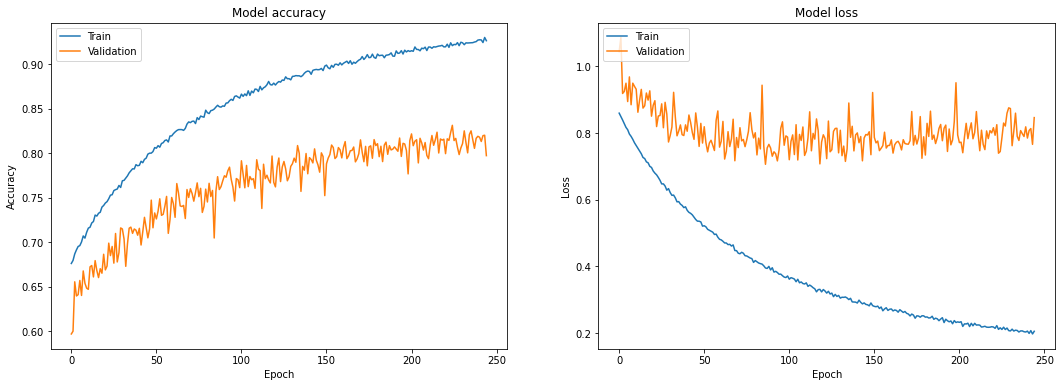

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(18, 6))

# Plot training & validation accuracy values

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score

predictions = model.predict(val_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_generator.classes
class_names = val_generator.class_indices.keys()

print("Model Accuracy on test set: {:.4f}".format(accuracy_score(y_test, y_pred)))

Model Accuracy on test set: 0.8029


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       990
           1       0.93      0.78      0.85       162
           2       0.71      0.79      0.75      1025
           3       0.90      0.96      0.93      1796
           4       0.86      0.71      0.78      1734
           5       0.74      0.84      0.79       414
           6       0.59      0.59      0.59       602

    accuracy                           0.80      6723
   macro avg       0.79      0.78      0.78      6723
weighted avg       0.81      0.80      0.80      6723



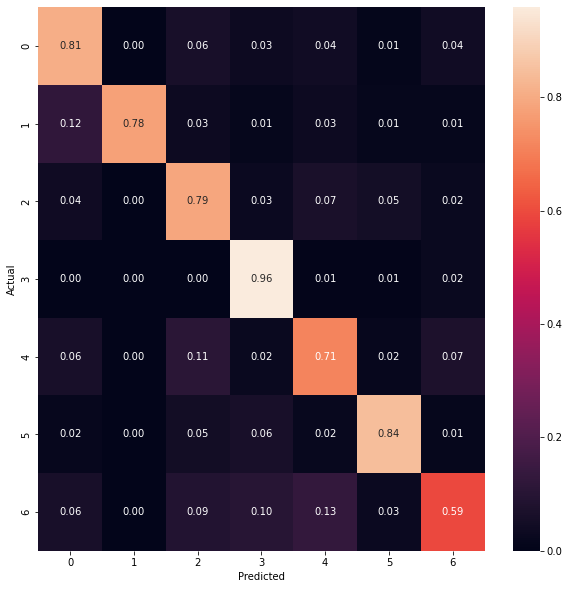

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_test = ImageDataGenerator(featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        shear_range=.2,
                        horizontal_flip=True)

test_generator = datagen_test.flow_from_directory(test_dir,
                                                target_size=(48,48),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                shuffle=False) 

Found 106 images belonging to 7 classes.


In [23]:
scores = model.evaluate(test_generator, verbose=1)
print("\nModel Evaluate Accuracy: %.2f%%" % (scores[1]*100))
print("Loss : ",scores[0])

4/4 [==============================] - 0s 57ms/step - loss: 1.1347 - accuracy: 0.8019

Model Evaluate Accuracy: 80.19%
Loss :  1.1346858739852905


In [25]:
predictions = model.predict(test_generator)
Y_pred = [np.argmax(probas) for probas in predictions]
Y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

print("Model Predict Accuracy on test set: {:.4f}".format(accuracy_score(Y_test, Y_pred)))

Model Predict Accuracy on test set: 0.8019


In [26]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       1.00      0.80      0.89        15
           2       0.63      0.80      0.71        15
           3       0.83      1.00      0.91        15
           4       0.75      0.56      0.64        16
           5       0.81      0.87      0.84        15
           6       0.85      0.73      0.79        15

    accuracy                           0.80       106
   macro avg       0.81      0.80      0.80       106
weighted avg       0.81      0.80      0.80       106



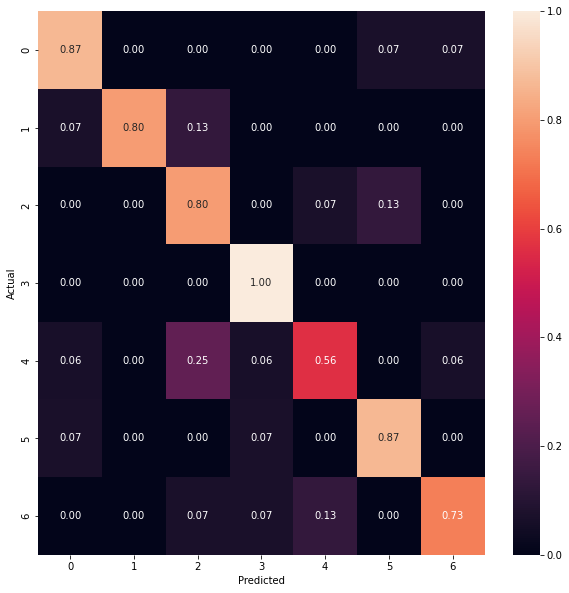

In [27]:
cm = confusion_matrix(Y_test, Y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [28]:
model_json = model.to_json()
with open("densenetmodif.json", "w") as json_file:
    json_file.write(model_json)